In [5]:
# General
import sys
import os
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import h5py

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
import scipy.io as sio

# Stats
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
from sklearn.decomposition import PCA

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15 
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 19
mpl.rcParams['figure.figsize'] = (6.85039, 4.79527) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)
labelfontsize = 12
tickfontsize = 12
figfontsize = 14

In [7]:
# Load the mine layout DataFrame.
simple_maze_f = '/scratch/dscho/time_cells/unity/maps/simple_maze.pkl'
simple_maze = dio.open_pickle(simple_maze_f)
simple_maze['coords'] = simple_maze['coords'].apply(lambda x: [(x[0][0]-3, x[0][1]), (x[1][0]-3, x[1][1])])

# Load events.
subj_sess = 'U518_ses0'
sampling_rate = 30000

# --------------------------------------
subj, sess = subj_sess.split('_')
data_dir = '/scratch/dscho/time_cells/data'
analysis_dir = '/scratch/dscho/time_cells/analysis'
subj_dir = os.path.join(data_dir, subj, sess)
events_dir = os.path.join(subj_dir, 'events')
spikes_dir = os.path.join(subj_dir, 'spikes', 'wave_clus3_autosort')
micros_dir = os.path.join(subj_dir, 'micro_lfps')
sync_dir = os.path.join(subj_dir, 'sync')
sr = sampling_rate

df1 = dio.open_pickle(os.path.join(analysis_dir, 'events', 'U518_ses0-events_formatted.pkl'))
df1.insert(0, 'sess', 0)
df2 = dio.open_pickle(os.path.join(analysis_dir, 'events', 'U518_ses1-events_formatted.pkl'))
df2.insert(0, 'sess', 1)
events = pd.concat((df1, df2)).reset_index(drop=True)

In [8]:
# Get the cumulative number of golds obtained over trials
# in each session.
select = list(events.query("(key=='score')")['value'][events.query("(key=='score')")['value'].apply(lambda x: x['scoreChange']==10)].index)
events.loc[select]

trials = [(int(i / 36), (i%36)+1) for i in range(72)]
n_trials = len(trials)

gold_by_trial = []
for sess, trial in trials:
    gold_by_trial.append(len(events.loc[select].query("(sess=={}) & (trial=={})".format(sess, trial))))
gold_by_trial = np.cumsum(gold_by_trial)

In [9]:
# Get the digging accuracy for each trial.
select_pos = list(events.query("(key=='dig')")['value'][events.query("(key=='dig')")['value'].apply(lambda x: x['successful'])].index)
select_neg = list(events.query("(key=='dig')")['value'][events.query("(key=='dig')")['value'].apply(lambda x: not x['successful'])].index)

trials = [(int(i / 36), (i%36)+1) for i in range(72)]
n_trials = len(trials)

digacc_by_trial = []
for sess, trial in trials:
    n_succ = len(events.loc[select_pos].query("(sess=={}) & (trial=={})".format(sess, trial)))
    n_fail = len(events.loc[select_neg].query("(sess=={}) & (trial=={})".format(sess, trial)))
    
    if n_succ + n_fail > 0:
        digacc_by_trial.append(100 * (n_succ / (n_succ+n_fail)))
    else:
        digacc_by_trial.append(-100)

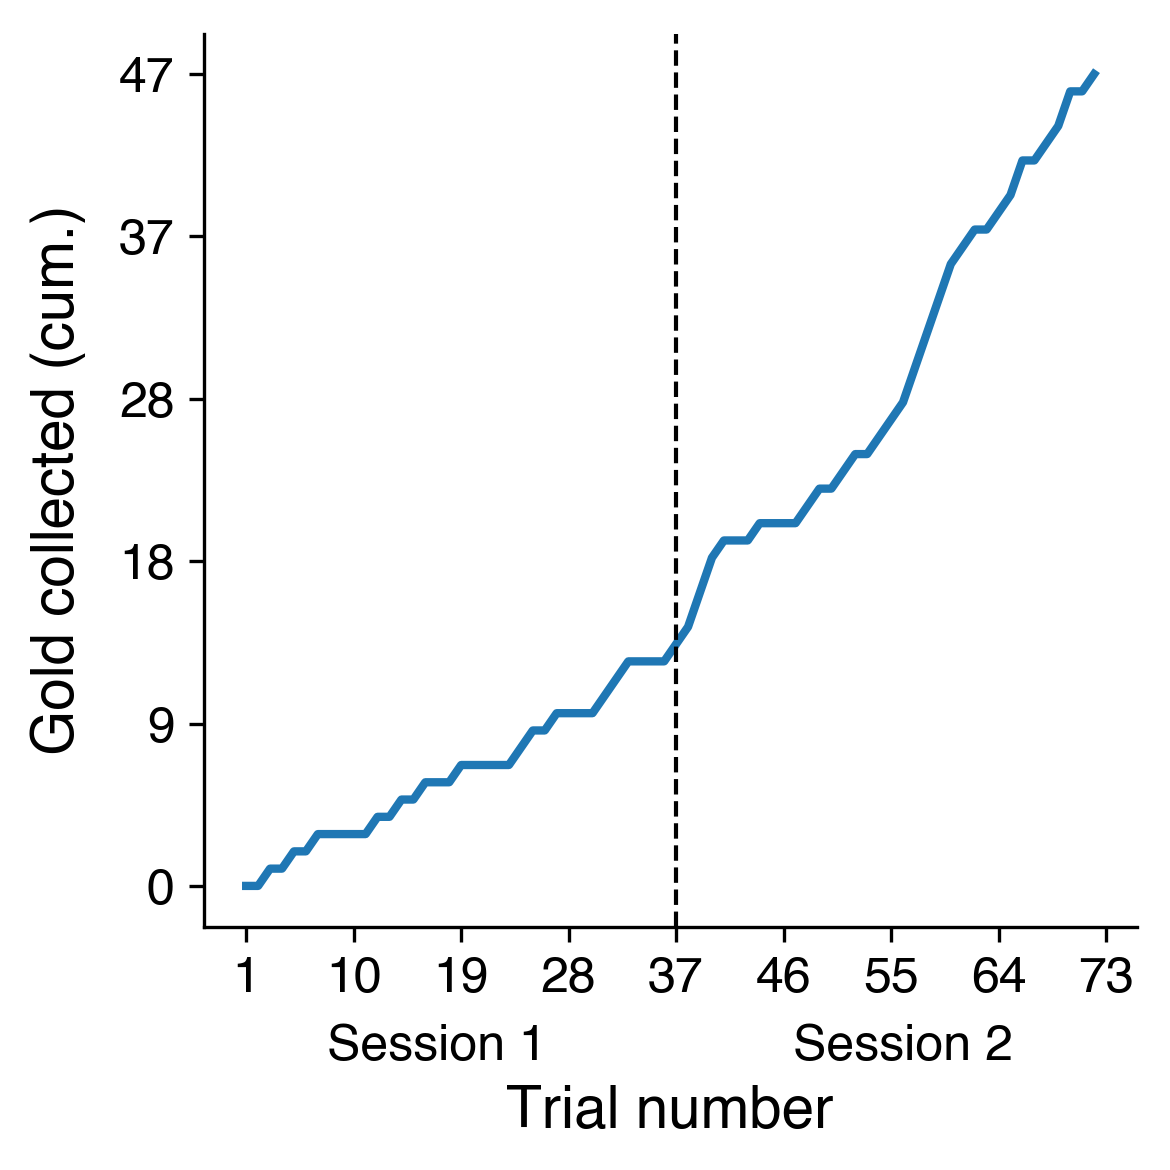

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

i = 0
ax[i].plot(np.arange(n_trials), gold_by_trial, linewidth=2)
ax[i].axvline(n_trials/2, 0, gold_by_trial[-1], 
              color='k', linewidth=1, linestyle='--')
ax[i].set_xticks(np.linspace(0, n_trials, 9))
ax[i].set_xticklabels(np.linspace(1, n_trials+1, 9, dtype=int), fontsize=tickfontsize)
ax[i].set_yticks(np.linspace(0, gold_by_trial[-1], 6))
ax[i].set_yticklabels(np.linspace(0, gold_by_trial[-1], 6, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Trial number', fontsize=labelfontsize, labelpad=20)
ax[i].set_ylabel('Gold collected (cum.)', fontsize=labelfontsize, labelpad=8)
ax[i].annotate('Session 1', (0.25, -0.15), xycoords='axes fraction', fontsize=tickfontsize, ha='center')
ax[i].annotate('Session 2', (0.75, -0.15), xycoords='axes fraction', fontsize=tickfontsize, ha='center')

fig.tight_layout()

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/U518_behav1.png', 
                format='png', dpi=300, bbox_inches='tight')

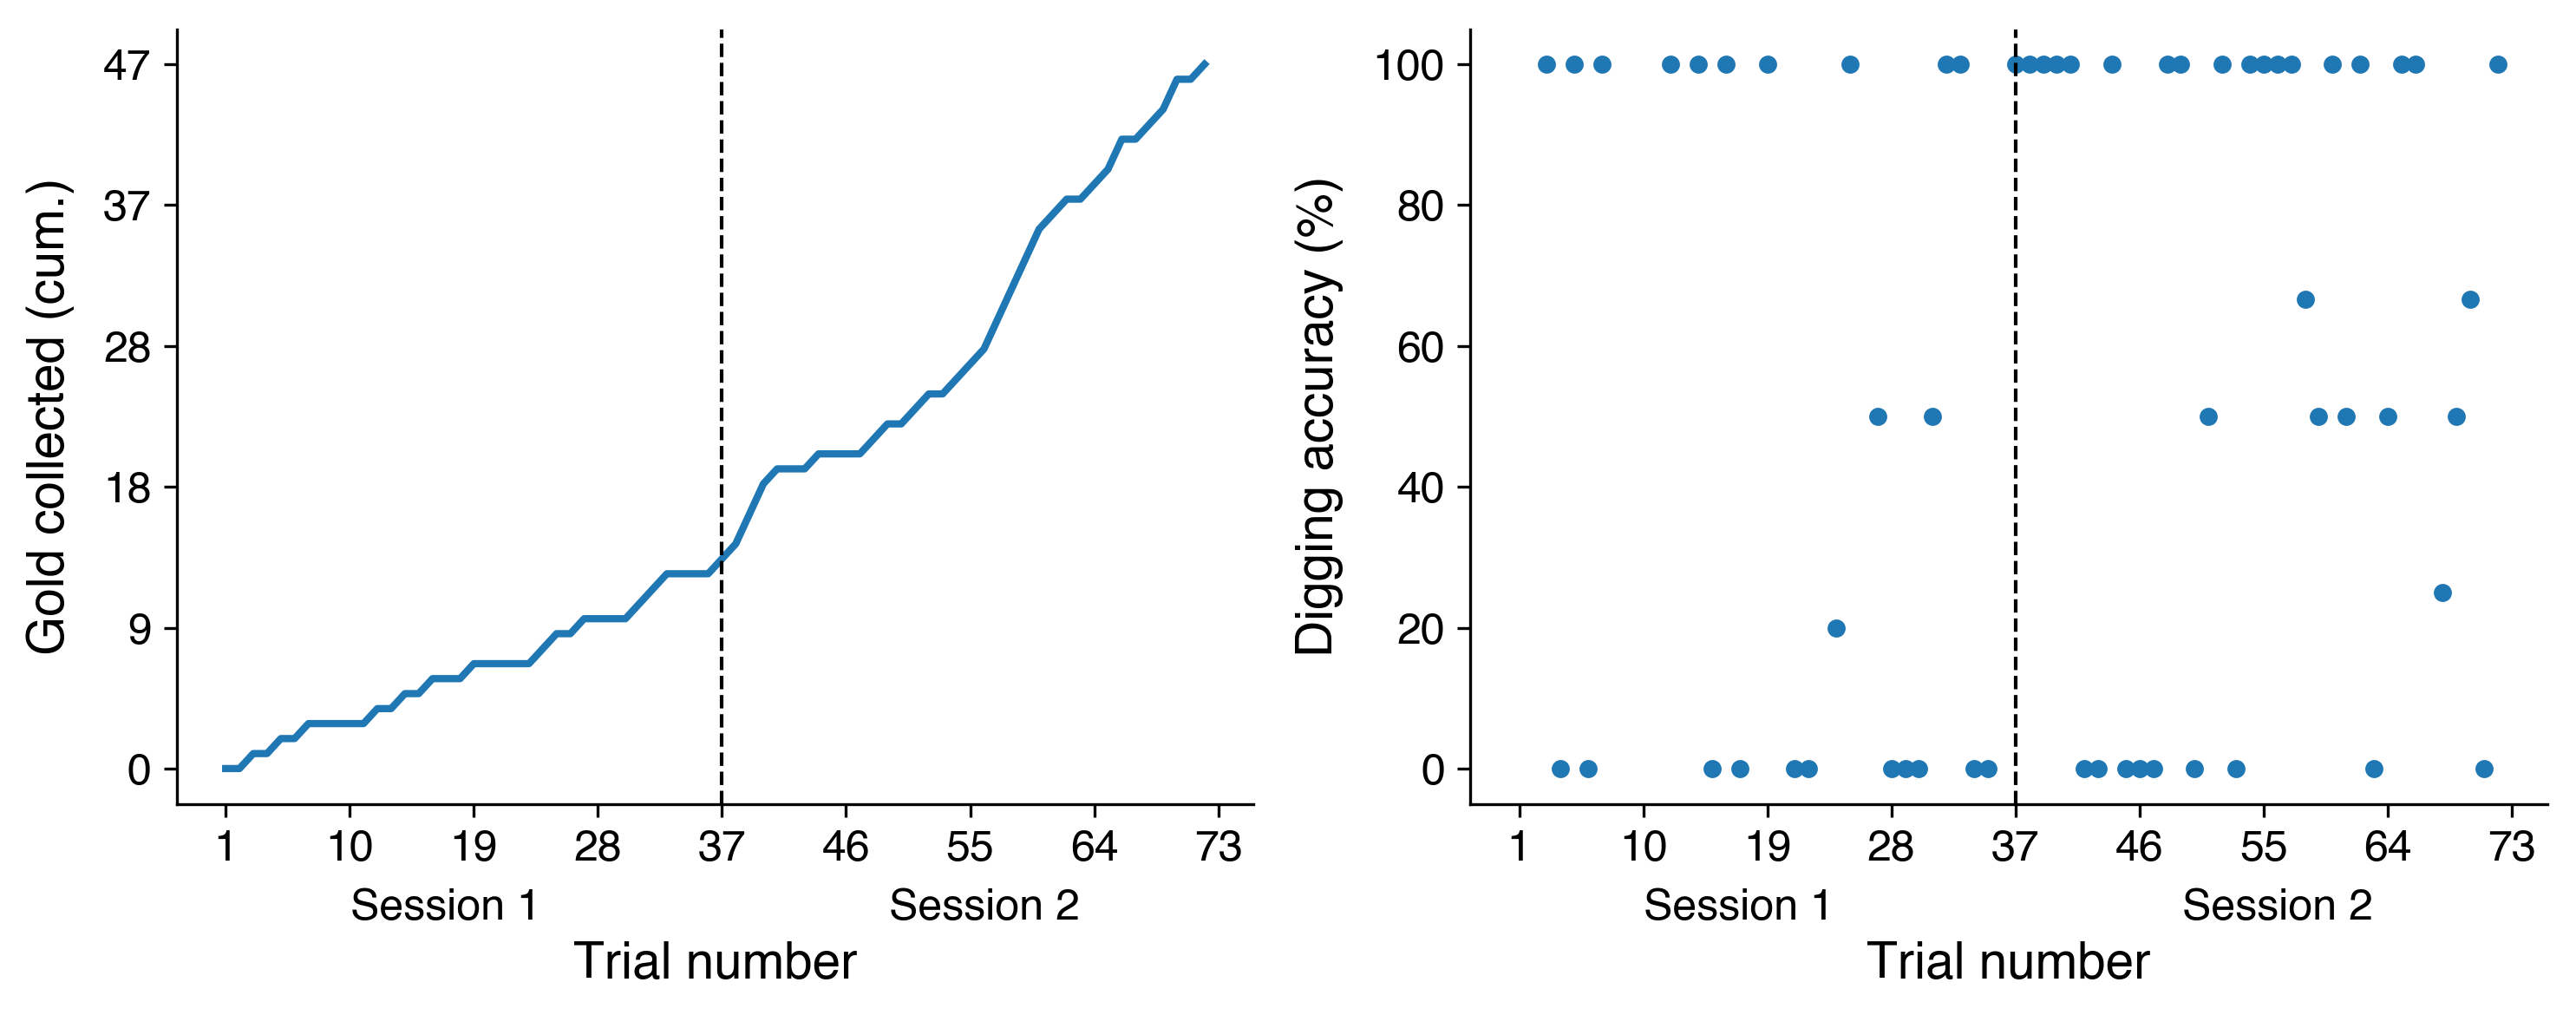

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14

i = 0
ax[i].plot(np.arange(n_trials), gold_by_trial, linewidth=2)
ax[i].axvline(n_trials/2, 0, gold_by_trial[-1], 
              color='k', linewidth=1, linestyle='--')
ax[i].set_xticks(np.linspace(0, n_trials, 9))
ax[i].set_xticklabels(np.linspace(1, n_trials+1, 9, dtype=int), fontsize=tickfontsize)
ax[i].set_yticks(np.linspace(0, gold_by_trial[-1], 6))
ax[i].set_yticklabels(np.linspace(0, gold_by_trial[-1], 6, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Trial number', fontsize=labelfontsize, labelpad=20)
ax[i].set_ylabel('Gold collected (cum.)', fontsize=labelfontsize, labelpad=8)
ax[i].annotate('Session 1', (0.25, -0.15), xycoords='axes fraction', fontsize=tickfontsize, ha='center')
ax[i].annotate('Session 2', (0.75, -0.15), xycoords='axes fraction', fontsize=tickfontsize, ha='center')

i = 1
ax[i].scatter(np.arange(n_trials), digacc_by_trial, linewidth=2)
ax[i].axvline(n_trials/2, 0, gold_by_trial[-1], 
              color='k', linewidth=1, linestyle='--')
ax[i].set_xticks(np.linspace(0, n_trials, 9))
ax[i].set_xticklabels(np.linspace(1, n_trials+1, 9, dtype=int), fontsize=tickfontsize)
ax[i].set_ylim([-5, 105])
ax[i].set_yticks(np.linspace(0, 100, 6))
ax[i].set_yticklabels(np.linspace(0, 100, 6, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('Trial number', fontsize=labelfontsize, labelpad=20)
ax[i].set_ylabel('Digging accuracy (%)', fontsize=labelfontsize, labelpad=8)
ax[i].annotate('Session 1', (0.25, -0.15), xycoords='axes fraction', fontsize=tickfontsize, ha='center')
ax[i].annotate('Session 2', (0.75, -0.15), xycoords='axes fraction', fontsize=tickfontsize, ha='center')

fig.tight_layout()

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/U518_behav1.png', 
                format='png', dpi=300, bbox_inches='tight')

In [12]:
# For what percent of encoding/retrieval trials was the subject 
# already back at the base when 30 sec were up?
rtb_inds = np.array(events.query("(key=='gameState')")[events.query("(key=='gameState')")['value'].apply(lambda x: x['stateName']=='ReturnToBase')].index)
position_inds = np.array(events.query("(key=='playerTransform')").index)

x = np.expand_dims(rtb_inds, 1) - position_inds # rtb x position
x[x<0] = 1e6
back_at_base = events.loc[position_inds[x.argmin(axis=1)]].copy()
back_at_base['at_base'] = back_at_base['value'].apply(lambda x: 100 * x['playerAtBase']).tolist()
# at_base_pct = df.groupby(['gameState', 'time_penalty']).agg({'key': len, 'at_base': lambda x: 100 * np.mean(x)}).reset_index()

In [13]:
# What percent of golds were dug by trial?
cols = ['sess', 'trial', 'time_penalty', 'gold_spawned', 'gold_dug', 'pct_dug']
digging = []
for idx, df in events.groupby(['sess', 'trial']):
    sess, trial = idx
    gold_spawned = df.query("(key=='goldSpawned')")['value'].apply(lambda x: x['nItems']).tolist()[0]
    gold_dug = len(df.query("(key=='dig')")[df.query("(key=='dig')")['value'].apply(lambda x: x['successful'])])
    digging.append([sess, trial, df.iloc[0]['time_penalty'], gold_spawned, gold_dug, (100 * gold_dug)/gold_spawned])
    
digging = pd.DataFrame(digging, columns=cols)  

In [14]:
# How much distance is traveled, and much time spent moving vs. standing still?
cols = ['sess', 'trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
travel = []
for idx, df in events.query("(key=='playerTransform') & (gameState==['Encoding', 'Retrieval'])").groupby(['sess', 'trial', 'gameState']):
    sess, trial, gameState = idx
    pos = np.array(df['value'].apply(lambda x: (x['positionX'], x['positionZ'])).tolist())
    dist_trav = np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))
    travel.append([sess, trial, gameState, df.iloc[0]['time_penalty'], np.sum(dist_trav), 100 * np.mean(dist_trav>0)])
    
travel = pd.DataFrame(travel, columns=cols)

In [369]:
model = ols('at_base ~ C(gameState) * C(time_penalty)', back_at_base).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

print('Minus the interaction\n---------------------')
model = ols('at_base ~ C(gameState) + C(time_penalty)', back_at_base).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

Overall model F(3,140) = 4.03, p = 0.0088

                                     sum_sq     df         F    PR(>F)
C(gameState)                    4444.444444    1.0  1.914530  0.168663
C(time_penalty)                22500.000000    1.0  9.692308  0.002244
C(gameState):C(time_penalty)    1111.111111    1.0  0.478632  0.490188
Residual                      325000.000000  140.0       NaN       NaN

Minus the interaction
---------------------
Overall model F(2,141) = 5.82, p = 0.0037

                        sum_sq     df         F    PR(>F)
C(gameState)       4444.444444    1.0  1.921635  0.167865
C(time_penalty)   22500.000000    1.0  9.728279  0.002201
Residual         326111.111111  141.0       NaN       NaN



In [374]:
stats.ttest_ind(digging.query("(time_penalty==1)")['pct_dug'],
                digging.query("(time_penalty==0)")['pct_dug'])

Ttest_indResult(statistic=0.8471013680970426, pvalue=0.39982556637444033)

In [381]:
model = ols('dist_trav ~ C(gameState) * C(time_penalty)', travel).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

print('Minus the interaction\n---------------------')

model = ols('dist_trav ~ C(gameState) + C(time_penalty)', travel).fit()
print('Overall model F({:.0f},{:.0f}) = {:.2f}, p = {:.4f}'.format(model.df_model, model.df_resid, model.fvalue, model.f_pvalue), end='\n\n')
print(sm.stats.anova_lm(model, typ=2), end='\n\n')

Overall model F(3,140) = 0.78, p = 0.5045

                                    sum_sq     df         F    PR(>F)
C(gameState)                      6.838481    1.0  0.018721  0.891367
C(time_penalty)                 831.518226    1.0  2.276310  0.133618
C(gameState):C(time_penalty)     21.280905    1.0  0.058257  0.809625
Residual                      51140.910055  140.0       NaN       NaN

Minus the interaction
---------------------
Overall model F(2,141) = 1.16, p = 0.3179

                       sum_sq     df         F    PR(>F)
C(gameState)         6.838481    1.0  0.018846  0.891003
C(time_penalty)    831.518226    1.0  2.291616  0.132313
Residual         51162.190960  141.0       NaN       NaN



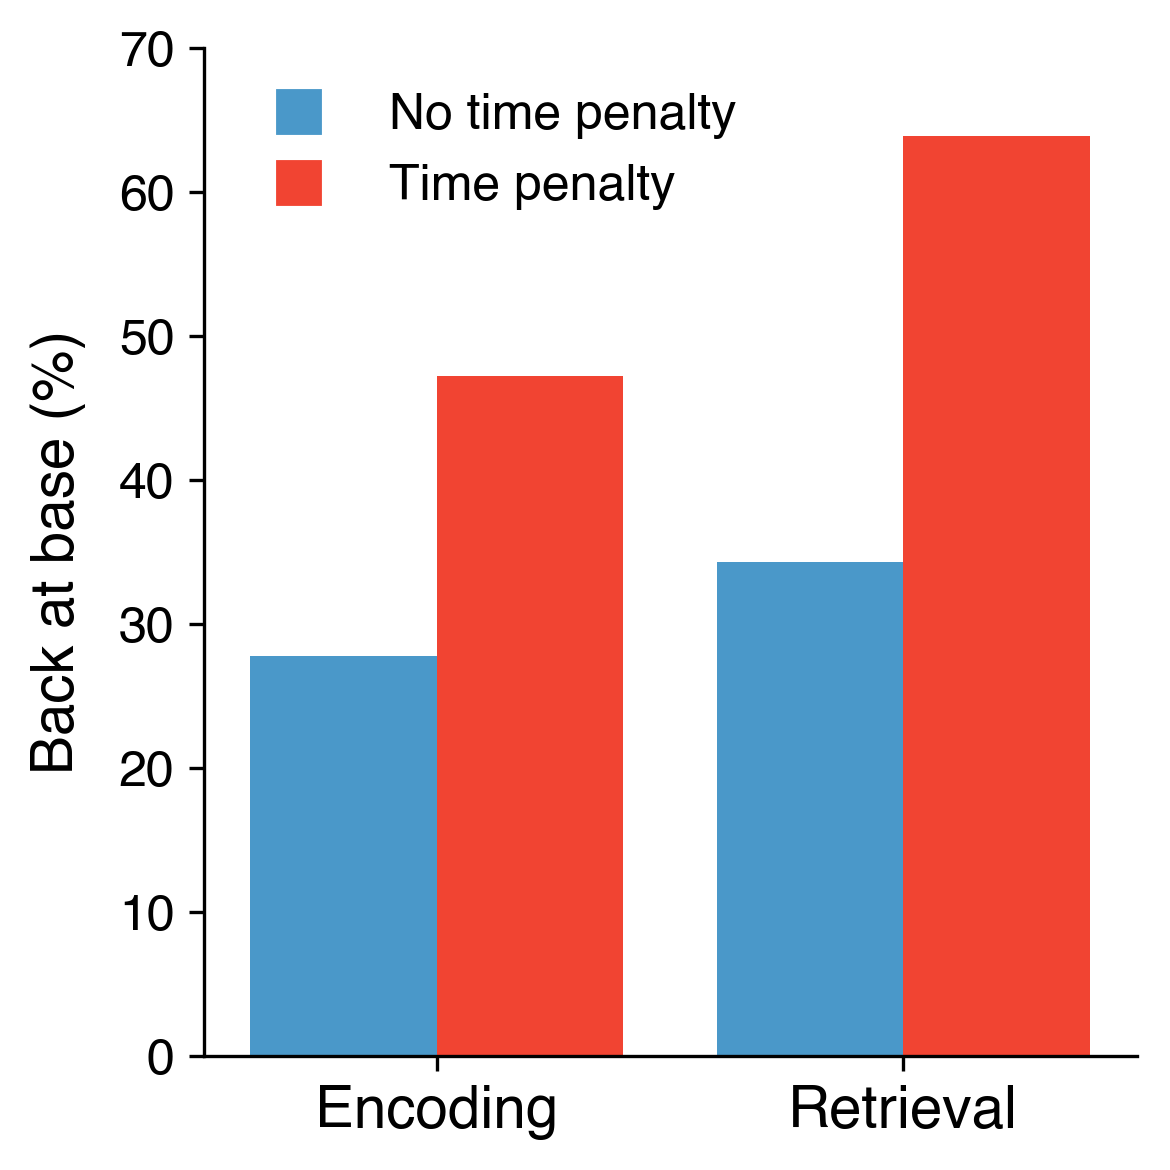

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14

i = 0
ax[i] = sns.barplot(x='gameState', y='at_base', hue='time_penalty', data=back_at_base, ax=ax[i],
                    ci=None, palette=colors, saturation=1)
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=labelfontsize)
ax[i].set_ylim([0, 70])
ax[i].set_yticks(np.linspace(0, 70, 8))
ax[i].set_yticklabels(np.linspace(0, 70, 8, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Back at base (%)', fontsize=labelfontsize, labelpad=8)

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=tickfontsize)]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=2)

fig.tight_layout()

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/U518_behav2.png', 
                format='png', dpi=300, bbox_inches='tight')

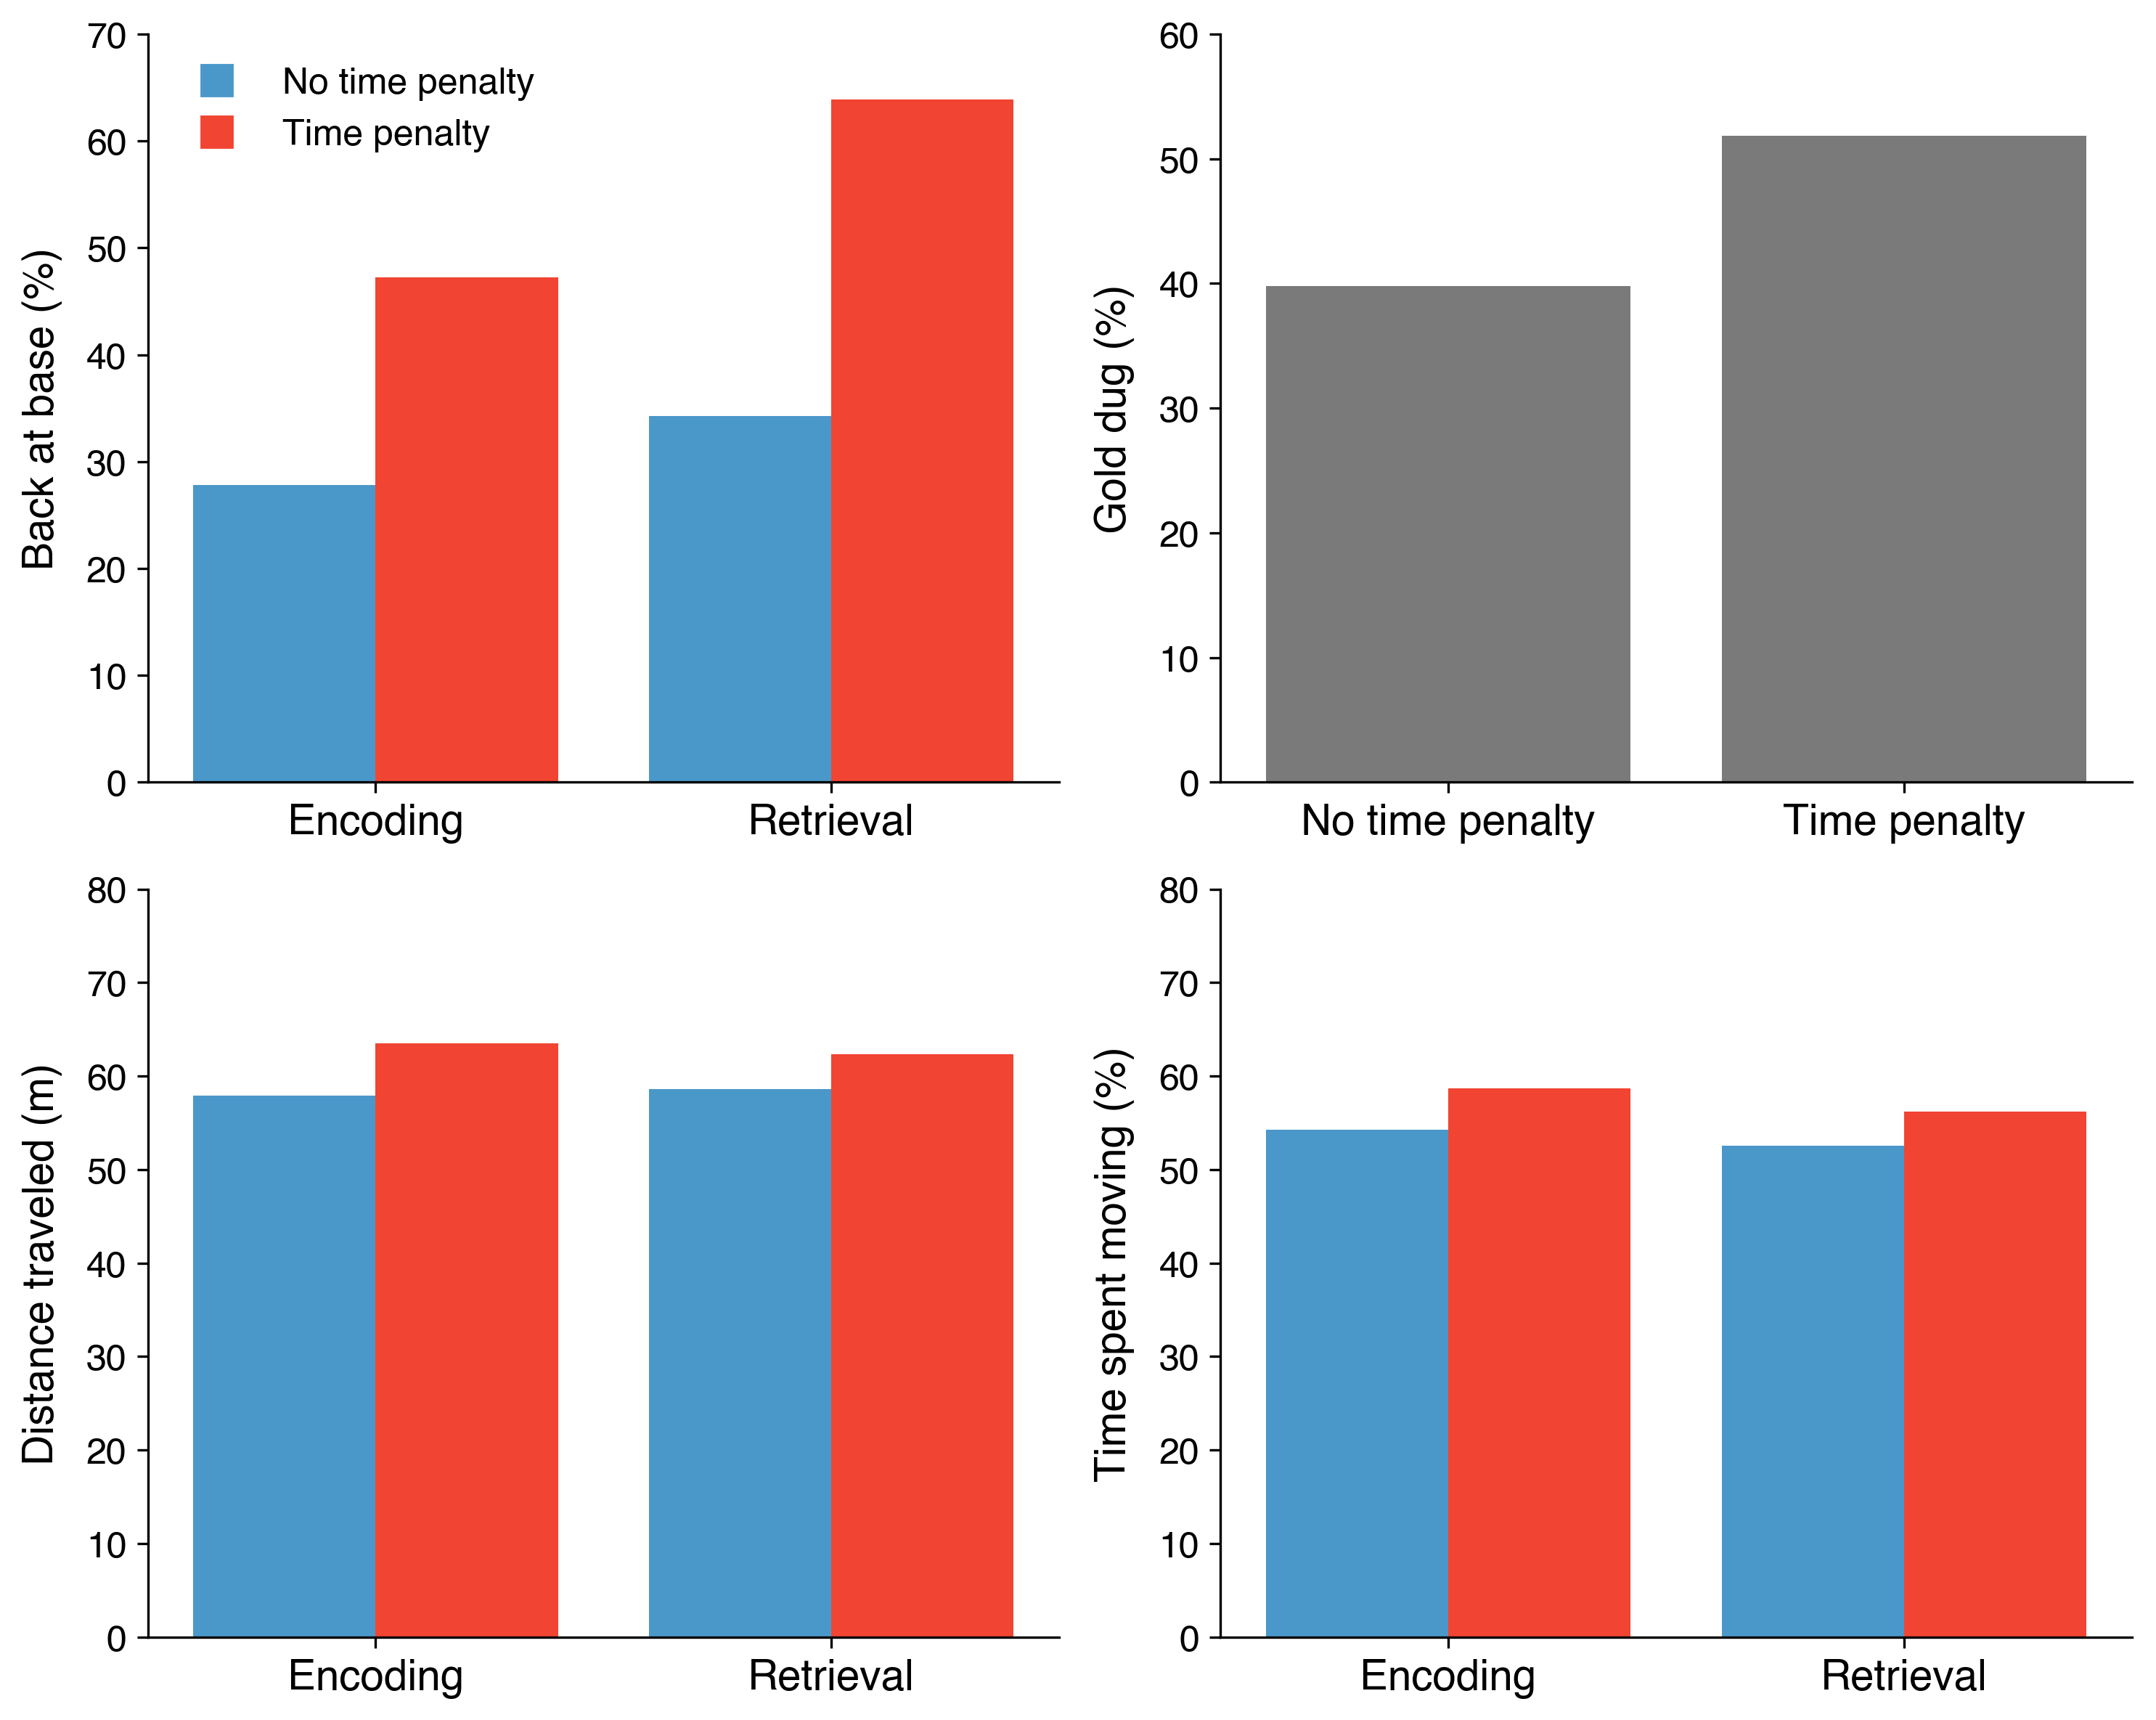

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14

i = 0
ax[i] = sns.barplot(x='gameState', y='at_base', hue='time_penalty', data=back_at_base, ax=ax[i],
                    ci=None, palette=colors, saturation=1)
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=labelfontsize)
ax[i].set_ylim([0, 70])
ax[i].set_yticks(np.linspace(0, 70, 8))
ax[i].set_yticklabels(np.linspace(0, 70, 8, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Back at base (%)', fontsize=labelfontsize, labelpad=8)

i = 1
ax[i] = sns.barplot(x='time_penalty', y='pct_dug', data=digging, ax=ax[i],
                    ci=None, color=colors[5], saturation=1)
ax[i].set_xticklabels(['No time penalty', 'Time penalty'], fontsize=labelfontsize)
ax[i].set_ylim([0, 60])
ax[i].set_yticks(np.linspace(0, 60, 7))
ax[i].set_yticklabels(np.linspace(0, 60, 7, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Gold dug (%)', fontsize=labelfontsize, labelpad=8)

i = 2
ax[i] = sns.barplot(x='gameState', y='dist_trav', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1)
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=labelfontsize)
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Distance traveled (m)', fontsize=labelfontsize, labelpad=8)
ax[i].get_legend().remove()

i = 3
ax[i] = sns.barplot(x='gameState', y='pct_moving', hue='time_penalty', data=travel, ax=ax[i],
                    ci=None, palette=colors, saturation=1)
ax[i].set_xticklabels(['Encoding', 'Retrieval'], fontsize=labelfontsize)
ax[i].set_ylim([0, 80])
ax[i].set_yticks(np.linspace(0, 80, 9))
ax[i].set_yticklabels(np.linspace(0, 80, 9, dtype=int), fontsize=tickfontsize)
ax[i].set_xlabel('', fontsize=labelfontsize, labelpad=8)
ax[i].set_ylabel('Time spent moving (%)', fontsize=labelfontsize, labelpad=8)
ax[i].get_legend().remove()

custom_lines = [Line2D([0], [0], marker='s', color='w', label='No time penalty', markerfacecolor=colors[0], markersize=tickfontsize),
                Line2D([0], [0], marker='s', color='w', label='Time penalty', markerfacecolor=colors[1], markersize=tickfontsize)]
legend = ax[0].legend(handles=custom_lines, fontsize=tickfontsize, loc=2)

fig.tight_layout()

if False:
    fig.savefig('/home1/dscho/projects/time_cells/figs/U518_behav2.png', 
                format='png', dpi=300, bbox_inches='tight')

In [583]:
events.head()

,sess,time,key,value,scene,trial,time_penalty,gameState,bad_trials
0,0,782610.306487,gameState,{'stateName': 'InitTrial'},SimpleMaze,1,0,InitTrial,
1,0,782610.306487,playerRespawnTransform,"{'positionX': 16.5, 'positionZ': 1.6, 'rotatio...",SimpleMaze,1,0,InitTrial,
2,0,782610.306487,baseDoorsOpen,"{'rightDoor': False, 'leftDoor': False, 'middl...",SimpleMaze,1,0,InitTrial,
3,0,782610.306487,canvasDisplay,"{'canvasName': 'MainCanvas', 'canvasChildObjec...",SimpleMaze,1,0,InitTrial,
4,0,782610.306487,canvasDisplay,"{'canvasName': 'MainCanvas', 'canvasChildObjec...",SimpleMaze,1,0,InitTrial,


In [600]:
# Where did the subject go in the mine?
min_traversals = 10
sessions = [0, 1]

# -------------------------------------
cols = ['sess', 'trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
game_states = ['Encoding', 'Retrieval', 'ReturnToBase1', 'ReturnToBase1']
mask_regions = ['wall', 'base']
simple_maze_map = []
mask = []
for i, sess in enumerate(sessions):
    traversals = []
    for idx, df in (events.query("(key=='playerTransform') & (sess=={}) & (gameState=={})".format(sess, game_states))
                    .groupby(['sess', 'trial', 'gameState'])):
        sess, trial, gameState = idx
        pos = np.array(df['value'].apply(lambda x: (int(x['positionX']-xoffset), int(x['positionZ']))).tolist())
        dist_trav = np.concatenate(([0], np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))))
        traversals.extend([x for x in pos[dist_trav>0]])
    traversals = np.array(traversals)
    positions, counts = np.unique(traversals, axis=0, return_counts=True)

    simple_maze_map.append(np.zeros([27, 29]))
    for iPos in range(len(positions)):
        simple_maze_map[i][tuple(positions[iPos])] = counts[iPos]
    
    # Mask out unwanted regions.
    mask.append(np.zeros([27, 29]))
    for region in mask_regions:
        for idx, row in simple_maze.query("(region=='{}')".format(region)).iterrows():
            (xmin, zmin), (xmax, zmax) = row.coords
            for x in range(xmin, xmax):
                for z in range(zmin, zmax):
                    simple_maze_map[i][x, z] = 0
                    mask[i][x, z] = 1

    # Mask out squares that the subject didn't visit.
    simple_maze_map[i][simple_maze_map[i]<min_traversals] = 0
    
    print('Session {}'.format(i))
    print('{} squares traversed'.format(simple_maze_map[i][simple_maze_map[i]>0].size))
    print('No. traversals: median {:.1f}, max {:.1f}, sum {:.0f}'.format(np.median(simple_maze_map[i][simple_maze_map[i]>0]), 
                                                                         np.max(simple_maze_map[i]), 
                                                                         np.sum(simple_maze_map[i])))

Session 0
217 squares traversed
No. traversals: median 15.0, max 43.0, sum 3708
Session 1
227 squares traversed
No. traversals: median 17.0, max 38.0, sum 4307


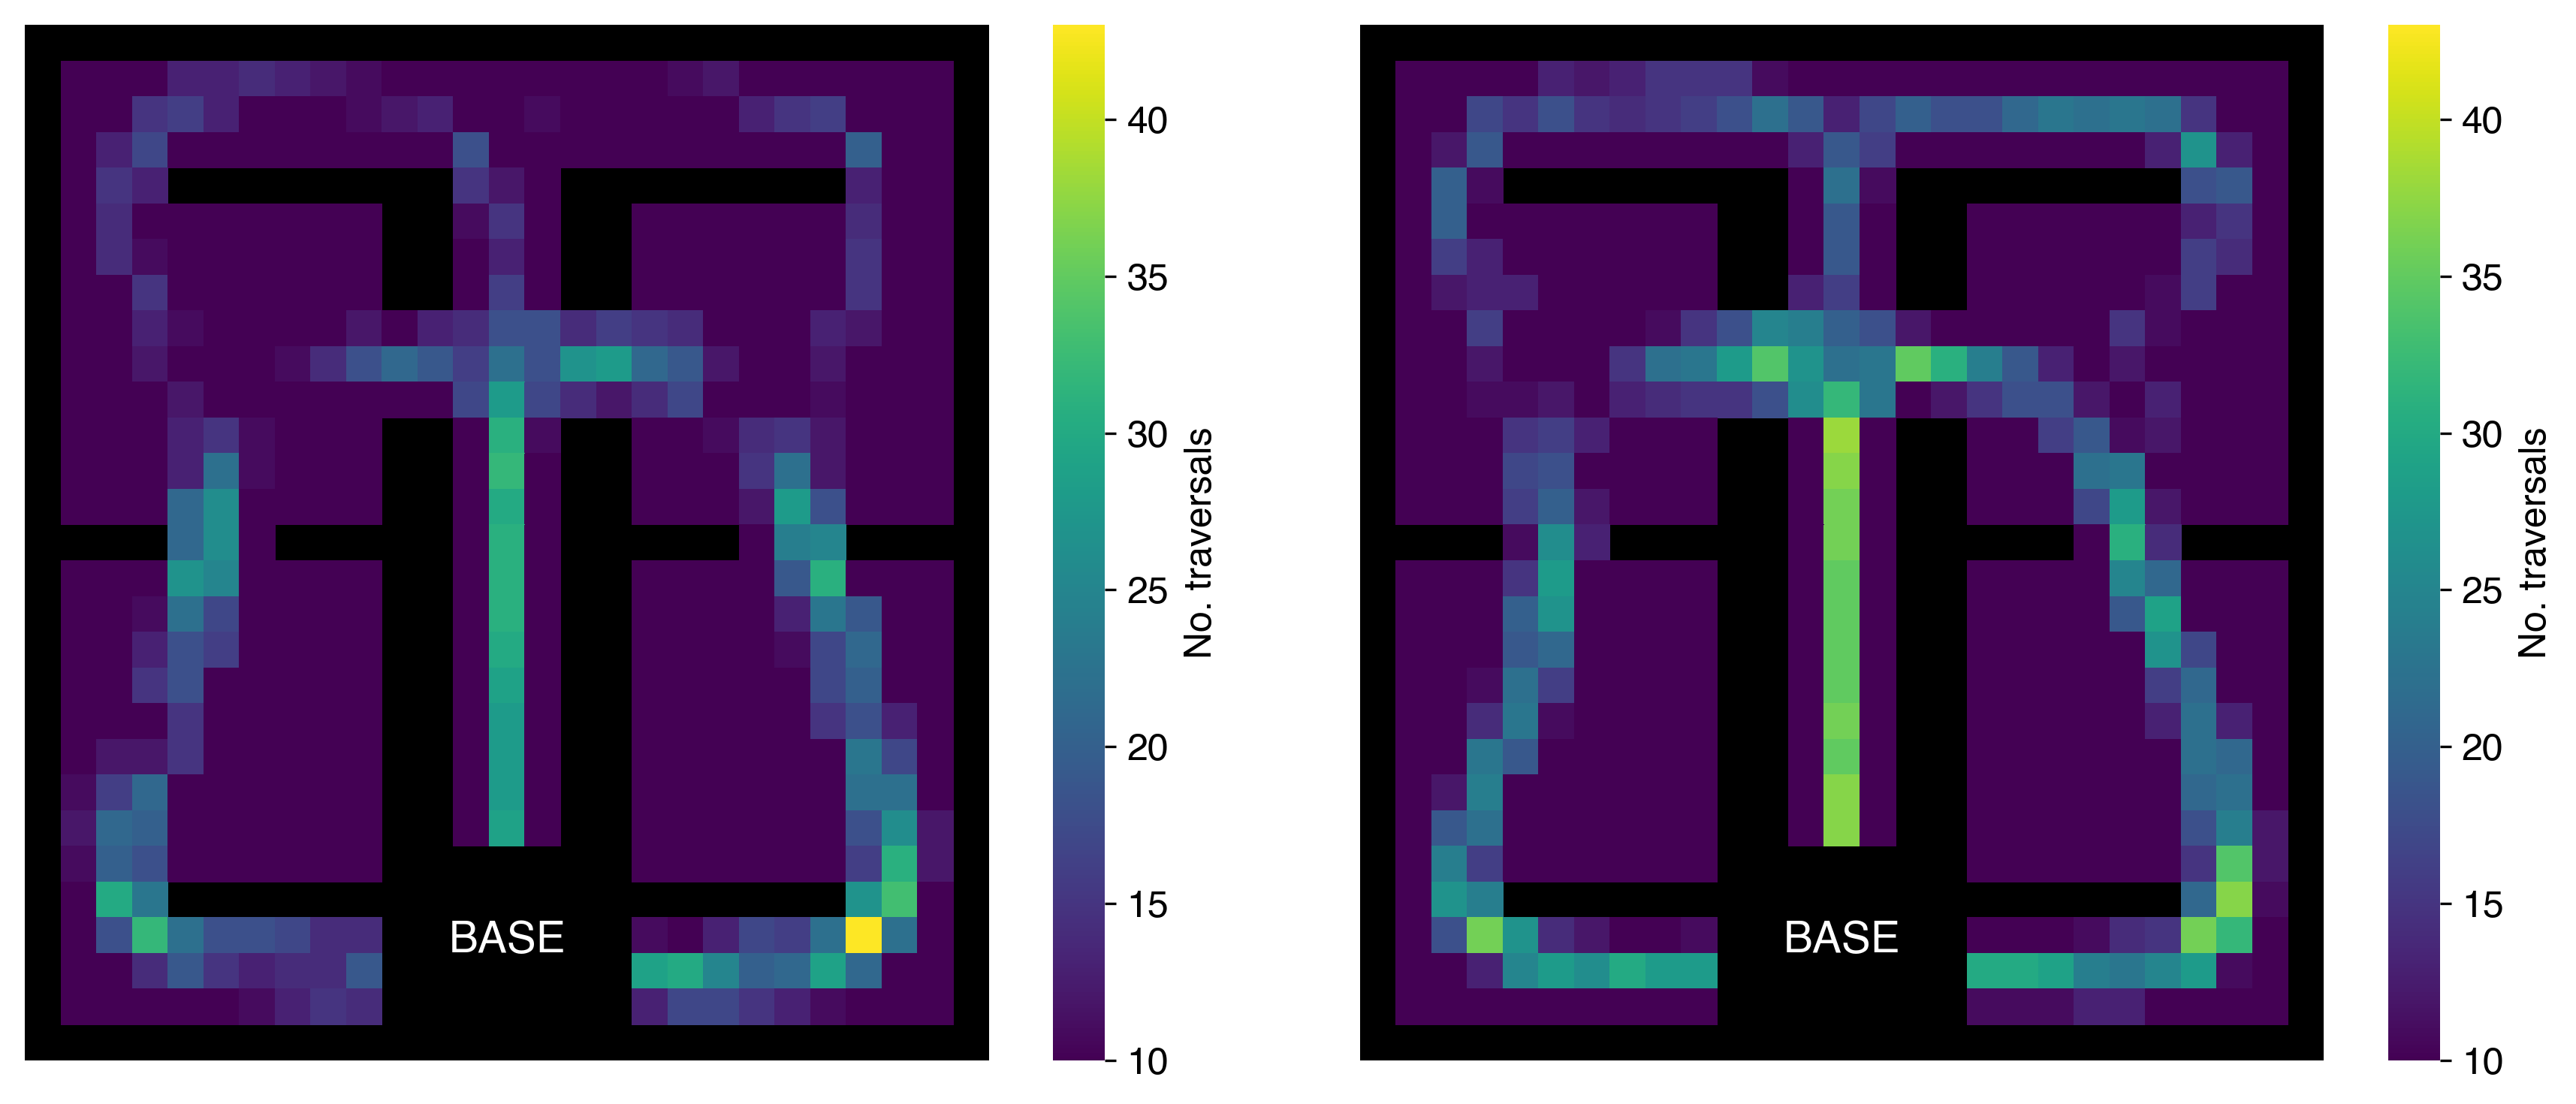

In [599]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14
cmap = [(0, 0, 0)] + sns.color_palette('viridis', 500)

vmax = np.max(np.vstack([x for x in simple_maze_map]))
for i in range(len(sessions)):
    ax[i] = sns.heatmap(simple_maze_map[i].T[::-1], vmin=min_traversals, vmax=vmax,
                        square=True, cmap='viridis', mask=mask[i].T[::-1], ax=ax[i])
    ax[i].annotate('BASE', (13.5, 26), color='w', fontsize=labelfontsize, ha='center')
    ax[i].set_facecolor('k')

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    cbar = ax[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=tickfontsize)
    cbar.set_ticks(np.arange(min_traversals, vmax+1, 5, dtype=int))
    cbar.set_ticklabels(np.arange(min_traversals, vmax+1, 5, dtype=int))
    cbar.set_label('No. traversals', fontsize=tickfontsize, labelpad=5)

fig.tight_layout()

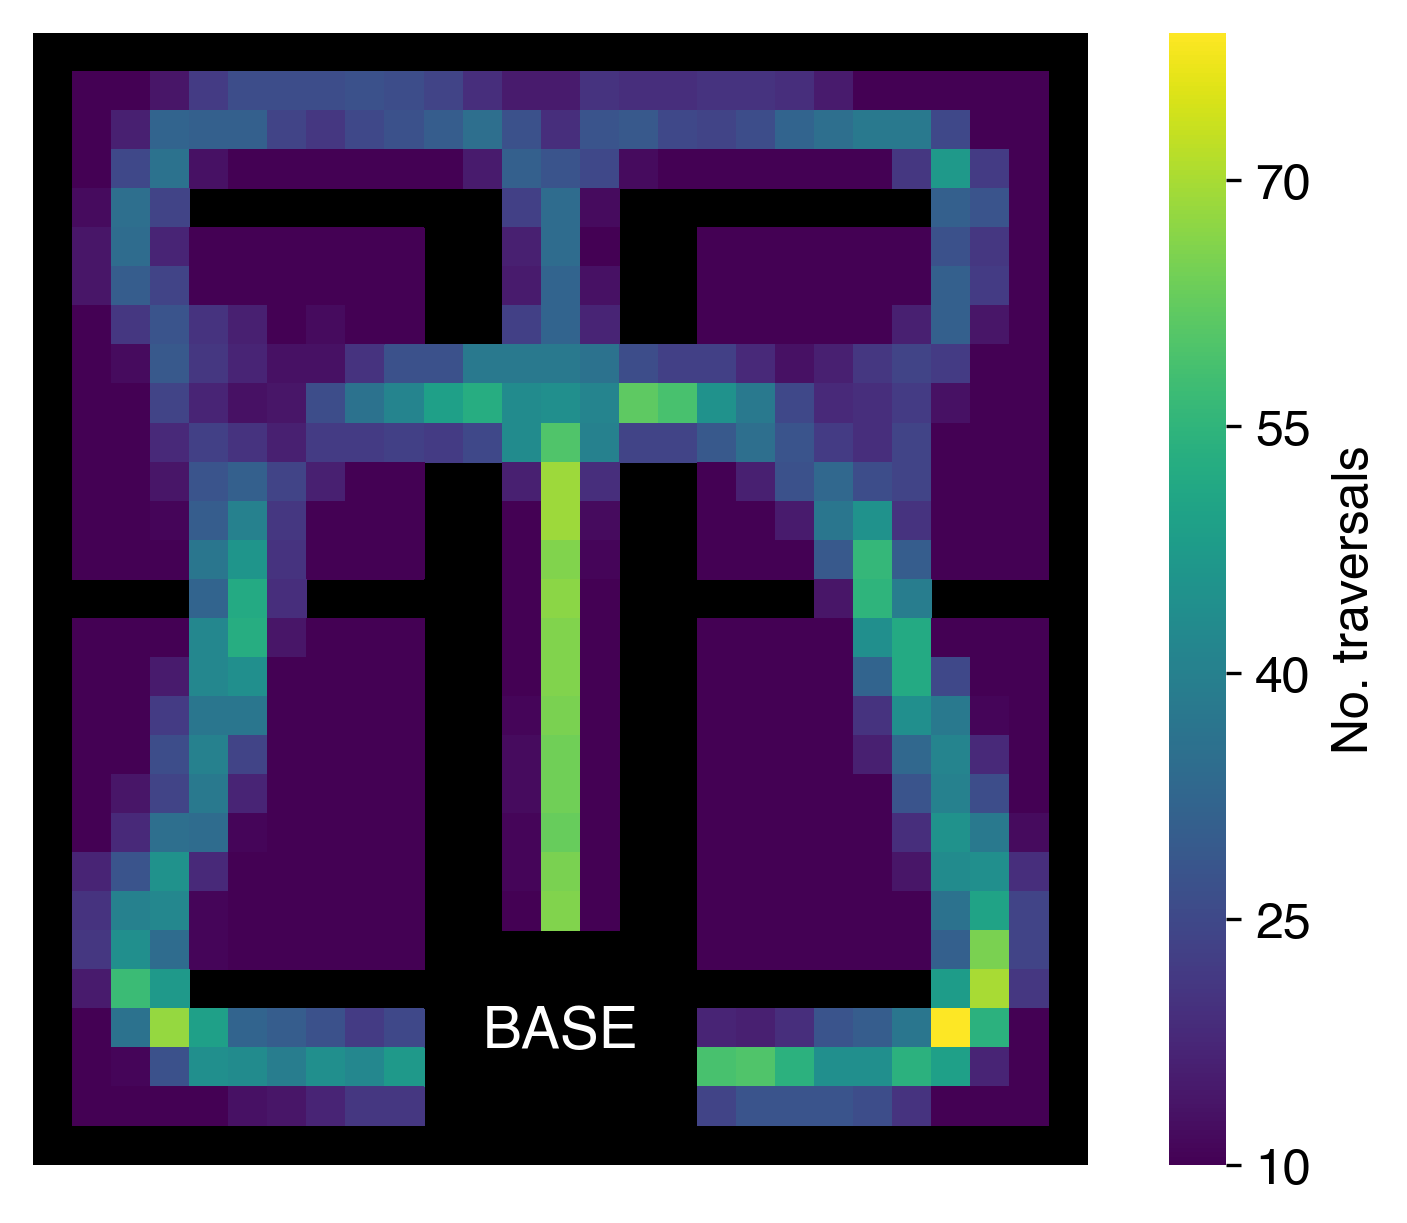

In [580]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=300)
ax = np.ravel(ax)

tickfontsize = 12
labelfontsize = 14
cmap = [(0, 0, 0)] + sns.color_palette('viridis', 500)

i = 0
ax[i] = sns.heatmap(simple_maze_map.T[::-1], vmin=min_traversals, vmax=np.max(simple_maze_map),
                    square=True, cmap='viridis', mask=mask.T[::-1], ax=ax[i])
ax[i].annotate('BASE', (13.5, 26), color='w', fontsize=labelfontsize, ha='center')
ax[i].set_facecolor('k')

ax[i].set_xticks([])
ax[i].set_yticks([])
cbar = ax[i].collections[0].colorbar
cbar.ax.tick_params(labelsize=tickfontsize)
cbar.set_ticks(np.arange(min_traversals, np.max(simple_maze_map)+1, 15, dtype=int))
cbar.set_ticklabels(np.arange(min_traversals, np.max(simple_maze_map)+1, 15, dtype=int))
cbar.set_label('No. traversals', fontsize=tickfontsize, labelpad=5)

fig.show()

In [ ]:
# How much distance is travelled, and much time spent moving vs. standing still?
cols = ['sess', 'trial', 'gameState', 'time_penalty', 'dist_trav', 'pct_moving']
travel = []
positions = []
for idx, df in events.query("(key=='playerTransform') & (gameState==['Encoding', 'Retrieval'])").groupby(['sess', 'trial', 'gameState']):
    sess, trial, gameState = idx
    pos = np.array(df['value'].apply(lambda x: (x['positionX'], x['positionZ'])).tolist())
    dist_trav = np.sqrt(np.sum(np.diff(pos, axis=0)**2, axis=1))
    travel.append([sess, trial, gameState, df.iloc[0]['time_penalty'], np.sum(dist_trav), 100 * np.mean(dist_trav>0)])
    
travel = pd.DataFrame(travel, columns=cols)

In [318]:
travel.groupby(['gameState', 'time_penalty']).agg({'sess': len, 'dist_trav': lambda x: np.mean(x)}).reset_index()

,gameState,time_penalty,sess,dist_trav
0,Encoding,0,36,57.948854
1,Encoding,1,36,63.523718
2,Retrieval,0,36,58.281867
3,Retrieval,1,36,62.319022


In [130]:
player_positions.head()

,sess,time,key,value,scene,trial,time_penalty,gameState,bad_trials,place_field_idx
0,0,792727.420473,playerTransform,"{'positionX': 16.5, 'positionZ': 1.6, 'rotatio...",SimpleMaze,1,0,Encoding,,56
1,0,792776.421025,playerTransform,"{'positionX': 16.5, 'positionZ': 1.6, 'rotatio...",SimpleMaze,1,0,Encoding,,56
2,0,792827.421599,playerTransform,"{'positionX': 16.5, 'positionZ': 1.6, 'rotatio...",SimpleMaze,1,0,Encoding,,56
3,0,792876.422151,playerTransform,"{'positionX': 16.5, 'positionZ': 1.6, 'rotatio...",SimpleMaze,1,0,Encoding,,56
4,0,792926.422715,playerTransform,"{'positionX': 16.5, 'positionZ': 1.6, 'rotatio...",SimpleMaze,1,0,Encoding,,56


In [117]:
position_counts = player_positions.groupby('place_field_idx').size().reset_index()
position_counts.rename(columns={0: 'count'}, inplace=True)
position_counts.head()

,place_field_idx,count
0,0,1812
1,1,1652
2,2,1762
3,3,2041
4,4,2426


In [116]:
simple_maze.head()

,coords,hem,region,proxim,idx
0,"[(4, 1), (7, 4)]",L,hall,near,0
1,"[(7, 1), (10, 4)]",L,hall,near,1
2,"[(10, 1), (13, 4)]",L,hall,near,2
3,"[(20, 1), (23, 4)]",R,hall,near,2
4,"[(23, 1), (26, 4)]",R,hall,near,1


In [118]:
# Make a matrix
simple_maze_map = np.zeros([27, 29])
xoffset = 3

for _, row in position_counts.iterrows():
    place_field_idx, count = row
    coords = simple_maze.loc[simple_maze['idx']==place_field_idx]['coords']
    break

# for idx, row in simple_maze.query("(region=='wall')").iterrows():
#     (xmin, zmin), (xmax, zmax) = row.coords
#     xmin -= xoffset
#     xmax -= xoffset
#     for x in range(xmin, xmax):
#         for z in range(zmin, zmax):
#             simple_maze_map[x, z] = 0
            
# for idx, row in simple_maze.query("(region=='door')").iterrows():
#     (xmin, zmin), (xmax, zmax) = row.coords
#     xmin -= xoffset
#     xmax -= xoffset
#     for x in range(xmin, xmax):
#         for z in range(zmin, zmax):
#             simple_maze_map[x, z] = 0
            
# for idx, row in simple_maze.query("(region=='base')").iterrows():
#     (xmin, zmin), (xmax, zmax) = row.coords
#     xmin -= xoffset
#     xmax -= xoffset
#     for x in range(xmin, xmax):
#         for z in range(zmin, zmax):
#             simple_maze_map[x, z] = 0.9
            
# for idx, row in simple_maze.query("(region=='room')").iterrows():
#     (xmin, zmin), (xmax, zmax) = row.coords
#     xmin -= xoffset
#     xmax -= xoffset
    
#     val = 0.2 * (row['idx'] / len(simple_maze.query("(region=='room') & (hem=='{}') & (proxim=='{}')"
#                                                     .format(row.hem, row.proxim))))
#     for x in range(xmin, xmax):
#         for z in range(zmin, zmax):
#             simple_maze_map[x, z] = val       
            
# for idx, row in simple_maze.query("(region=='hall')").iterrows():
#     (xmin, zmin), (xmax, zmax) = row.coords
#     xmin -= xoffset
#     xmax -= xoffset
#     val = 0.3 + (0.2 * (row['idx'] / len(simple_maze.query("(region=='hall') & (hem=='{}') & (proxim=='{}')"
#                                                            .format(row.hem, row.proxim)))))
#     for x in range(xmin, xmax):
#         for z in range(zmin, zmax):
#             simple_maze_map[x, z] = val

In [5]:
# Load spikes.
n_spike_thresh = 0
fr_thresh = 0.1

# --------------------------------------
spike_files = glob(os.path.join(spikes_dir, 'times*.mat'))
print('{} files'.format(len(spike_files)))

# Reorder spike files.
spike_fname = 'times_CSC{}.mat'
spike_files = [os.path.join(spikes_dir, spike_fname.format(chan))
               for chan in range(1, len(spike_files)+1)
               if os.path.exists(os.path.join(spikes_dir, spike_fname.format(chan)))]
print('{} files'.format(len(spike_files)))

# Get session length.
try:
    lfp_timestamps = np.squeeze(sio.loadmat(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'))['timeStamps'])
except NotImplementedError:
    with h5py.File(os.path.join(micros_dir, 'lfpTimeStamps_micro.mat'), 'r') as f:
        lfp_timestamps = np.squeeze(f['timeStamps'])
lfp_timestamps = lfp_timestamps * 1e3
session_length = (lfp_timestamps[-1] - lfp_timestamps[0]) * 1e-3 # in sec

# Get spike times.
chans = [int(os.path.basename(f).split('CSC')[1].split('.')[0]) for f in spike_files]
spike_dat = []
for iChan, spike_file in enumerate(spike_files):
    chan = chans[iChan]
    cluster_class = sio.loadmat(spike_file)['cluster_class']
    units = np.unique(cluster_class[:, 0])
    if len(units) > 1:
        for unit in range(1, len(units)):
            spike_times = cluster_class[:, 1][np.where(cluster_class[:, 0]==unit)[0]]
            n_spikes = len(spike_times)
            if n_spikes > n_spike_thresh:
                spike_dat.append([subj_sess, subj, sess, chan, unit, spike_times, n_spikes, n_spikes/session_length])
cols = ['subj_sess', 'subj', 'sess', 'chan', 'unit', 'spike_times', 'n_spikes', 'fr']
spike_dat = pd.DataFrame(spike_dat, columns=cols)
spike_dat = spike_dat.loc[spike_dat['fr']>fr_thresh].reset_index(drop=True)
print(spike_dat.shape)
print(spike_dat['fr'].describe())

# Add montage info for U515
def get_hemroi(chan):
    mont = od([('REC', np.arange(1, 9, dtype=int)),
               ('RTO', np.arange(9, 17, dtype=int)),
               ('RIP', np.arange(17, 25, dtype=int)),
               ('LA', np.arange(25, 33, dtype=int)),
               ('LMH', np.arange(33, 41, dtype=int)),
               ('LTO', np.arange(41, 49, dtype=int)),
               ('LAI', np.arange(49, 57, dtype=int)),
               ('LMTG', np.arange(57, 65, dtype=int)),
               ('LO', np.arange(65, 73, dtype=int)),
               ('LTPO', np.arange(73, 81, dtype=int)),
               ('LPC', np.arange(81, 89, dtype=int)),
               ('LPOSTI', np.arange(89, 97, dtype=int))])
    for hemroi, chans in mont.items():
        if chan in chans:
            return hemroi
spike_dat['hemroi'] = spike_dat['chan'].apply(lambda x: get_hemroi(x))

print('{} neurons'.format(len(spike_dat)))
spike_dat.groupby('hemroi').size()

96 files
96 files
(127, 8)
count    127.000000
mean       2.102160
std        3.407329
min        0.104797
25%        0.280897
50%        0.826253
75%        2.279952
max       21.102423
Name: fr, dtype: float64
127 neurons


hemroi
LA        10
LAI       10
LMH       12
LO         8
LPOSTI     6
LTO       29
LTPO      14
REC       15
RIP        4
RTO       19
dtype: int64